# Answering Business Questions using SQL

## Introduction

We are going to analyse the data from the "chinook.db". This file includes multiple tables with information about a music company (similar to iTunes). In particular, we can find a table for:
- Employee
- Customer
- Invoice
- Track
- Playlist
- Etc

For further information, a scheme has been also downloaded in the dataset folder.

This database has been downloaded from the DataQuest guided project page.

## Importing libraries and defining functions

We are going to use sqlite3 library to handle db files and pandas for data analysis/plots.

Moreover:
- We'll create some helper functions in python to save some time.
- We'll use a context manager to handle the connection to the SQLite database.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
# This function runs the query q and returns a dataframe
def run_query(q):
    with sqlite3.connect('my_datasets/chinook.db') as conn:
        return pd.read_sql(q, conn)  

In [3]:
# This function executes the command c with no return parameters
def run_command(c):
    with sqlite3.connect('my_datasets/chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
# This functions returns the tables and views names
def show_tables():
    q='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

Let's explore the existing tables and views in chinook.db using the show_tables function:

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Case 1: Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:
- **Regal**: Hip-Hop
- **Red Tone**: Punk
- **Meteor and the Girls**: Pop
- **Slim Jim Bites**: Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

Let's explore the TOP 10 genres in the USA:

In [6]:
#Let's look for the TOP 10 genres in the USA
q='''
WITH
    invoice_line_usa AS (
    SELECT
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )

SELECT
    g.name genre,
    COUNT(*) tracks_sold,
    CAST(COUNT(*) AS FLOAT) / (
        SELECT COUNT(*) FROM invoice_line_usa
        ) tracks_sold_perc
FROM invoice_line_usa ilu
INNER JOIN track t ON t.track_id = ilu.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''
# First run the function without assigning, to show the result
run_query(q)

,genre,tracks_sold,tracks_sold_perc
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [7]:
# Assign the output to the variable
genres_sales_usa = run_query(q)

In [8]:
# Preparing the dataframe, with genre as index
genres_sales_usa.set_index("genre", inplace=True)
genres_sales_usa

,tracks_sold,tracks_sold_perc
genre,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


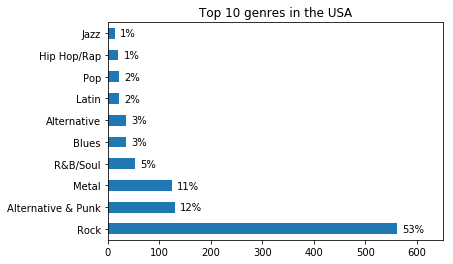

In [9]:
genres_sales_usa["tracks_sold"].plot.barh(
    title="Top 10 genres in the USA",
    xlim=(0,650)
)

plt.ylabel('')

for i, label in enumerate(list(genres_sales_usa.index)):
    score = genres_sales_usa.loc[label, "tracks_sold"]
    label = (genres_sales_usa.loc[label, "tracks_sold_perc"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i -0.15))

plt.show()

We can conclude from the gathered infromation that the 3 chosen artists will be:
- **Red Tone**: Punk
- **Meteor and the Girls**: Pop
- **Slim Jim Bites**: Blues

As their genres are sold better than hip-hop.

However, our goal should be to find rock artists, as they have more than 50% of the sales.

## Case 2: Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

In [10]:
q='''
WITH
    customer_total AS (
        SELECT
            customer_id,
            SUM(total) total,
            COUNT(invoice_id) num_of_invoices
        FROM invoice
        GROUP BY 1
    ),
    employee_total AS (
        SELECT
            c.support_rep_id employee_id,
            SUM(ct.total) total,
            SUM(ct.num_of_invoices) num_of_invoices,
            COUNT(c.customer_id) num_of_customers,
            CAST(SUM(ct.total) AS FLOAT) / CAST(SUM(ct.num_of_invoices) AS FLOAT) avg_per_invoice
        FROM customer c
        INNER JOIN customer_total ct ON c.customer_id = ct.customer_id
        GROUP BY 1
    )

SELECT 
    e.employee_id,
    e.first_name || " " || e.last_name employee_name,
    e.hire_date,
    et.total,
    et.num_of_customers,
    et.num_of_invoices,
    et.avg_per_invoice
FROM employee e
INNER JOIN employee_total et ON e.employee_id = et.employee_id
ORDER BY 4 DESC
'''
#We run the query without assigning to show the content as output
run_query(q)

,employee_id,employee_name,hire_date,total,num_of_customers,num_of_invoices,avg_per_invoice
0,3,Jane Peacock,2017-04-01 00:00:00,1731.51,21,212,8.167500
1,4,Margaret Park,2017-05-03 00:00:00,1584.00,20,214,7.401869
2,5,Steve Johnson,2017-10-17 00:00:00,1393.92,18,188,7.414468


We decided to have the following columns for our dataframe:
- **employee_id**: Just as information
- **employee_name**: As future dataframe index
- **hire_date**: To have a reference from the starting date, to take into account over the total sales
- **total**: Total amount from the employee sales
- **num_of_customers**: Number of customers assigned to the employee
- **num_of_invoices**: Number of invoices done by the customers from the employee
- **avg_per_invoice**: Average of money per invoice, considering the total column and num_of_invoices column.

In [11]:
#We store the dataframe into employee_sales variable
employee_sales = run_query(q)

In [12]:
employee_sales.set_index("employee_name", inplace=True)
#We can drop employee_id as it does not seem important for our analysis
employee_sales.drop(columns=["employee_id"],inplace=True)
employee_sales

,hire_date,total,num_of_customers,num_of_invoices,avg_per_invoice
employee_name,,,,,
Jane Peacock,2017-04-01 00:00:00,1731.51,21,212,8.167500
Margaret Park,2017-05-03 00:00:00,1584.00,20,214,7.401869
Steve Johnson,2017-10-17 00:00:00,1393.92,18,188,7.414468


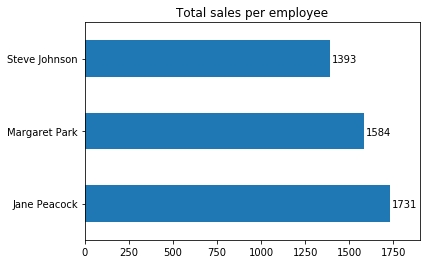

In [13]:
employee_sales["total"].plot.barh(
    title="Total sales per employee",
    xlim=(0,1900)
)

plt.ylabel("")

for i, label in enumerate(list(employee_sales.index)):
    score = employee_sales.loc[label, "total"]
    label = (employee_sales.loc[label, "total"]).astype(int)
    plt.annotate(str(label), (score + 10, i - 0.05))

plt.show()

We can see that JP is the one who sells the most but also the one who started working in the company earlier. SJ has a total of 1393$ but he has also worked in the company less than the others.

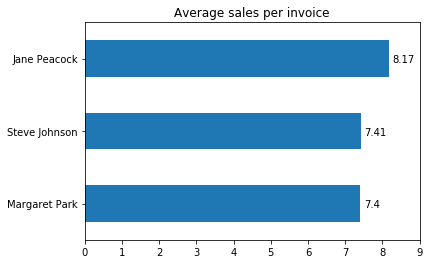

In [14]:
avg_invoice_sorted = employee_sales.sort_values("avg_per_invoice")
avg_invoice_sorted["avg_per_invoice"].plot.barh(
    title="Average sales per invoice",
    xlim=(0,9)
)

plt.ylabel("")

for i, label in enumerate(list(avg_invoice_sorted.index)):
    score = avg_invoice_sorted.loc[label, "avg_per_invoice"]
    label = round(avg_invoice_sorted.loc[label, "avg_per_invoice"],2)
    plt.annotate(str(label), (score + 0.1, i - 0.05))

plt.show()

Taking a look on the number of invoices and the average amount per invoice we can see that JP has better numbers than the other 2 coworkers. However, at this point SJ works similar to MP (and even a bit better) with an average amount per invoice of ~7,4\\$ vs the 8,1\\$ from JP.

## Case 3: Analyzing Sales by Country

Your next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, you should group these customers as "Other" in your analysis. 

In [15]:
q='''
WITH
    country_count AS (
        SELECT
            country,
            COUNT(customer_id) num_of_customers
        FROM customer
        GROUP BY 1
    ),
    new_customer_table AS (
        SELECT
            c.*,
            CASE
                WHEN cc.num_of_customers > 1 THEN cc.country
                ELSE "Other"
            END AS new_country_name,
            CASE
                WHEN cc.num_of_customers > 1 THEN 0
                ELSE 1
            END AS sort
        FROM customer c
        INNER JOIN country_count cc ON c.country = cc.country
    )

SELECT 
    c.new_country_name country_group,
    COUNT(DISTINCT c.customer_id) num_of_customers,
    COUNT(i.invoice_id) num_of_orders,
    SUM(i.total) total_sales,
    CAST(SUM(i.total) AS FLOAT) / CAST(COUNT(DISTINCT c.customer_id) AS FLOAT) avg_sales_per_customer,
    CAST(SUM(i.total) AS FLOAT) / CAST(COUNT(i.invoice_id) AS FLOAT) avg_sales_per_order
FROM new_customer_table c
INNER JOIN invoice i ON i.customer_id=c.customer_id
GROUP BY 1
ORDER BY c.sort ASC, 4 DESC
'''

run_query(q)

,country_group,num_of_customers,num_of_orders,total_sales,avg_sales_per_customer,avg_sales_per_order
0,USA,13,131,1040.49,80.037692,7.942672
1,Canada,8,76,535.59,66.948750,7.047237
2,Brazil,5,61,427.68,85.536000,7.011148
3,France,5,50,389.07,77.814000,7.781400
4,Germany,4,41,334.62,83.655000,8.161463
5,Czech Republic,2,30,273.24,136.620000,9.108000
6,United Kingdom,3,28,245.52,81.840000,8.768571
7,Portugal,2,29,185.13,92.565000,6.383793
8,India,2,21,183.15,91.575000,8.721429
9,Other,15,147,1094.94,72.996000,7.448571


**Notes**:

We created 2 new columns in customer:
- new_country_name: preserve the original name is it has more than one customer or, otherwise, takes "Other" as value.
- sort: is 0 if the new_country_name is not "Other" and 1 in case it is "Other".

These new columns have been used to group rows (new_country_name column) and to sort (sort column), keeping "Other" category at the bottom of the table.

Also take into account that, after grouping values, the number of customers is the amount of DIFFERENT customer_id that exist. That means we need to use COUNT(DISTINCT customer_id). If we don't use DISTINCT, repeated values will be counted more than once.

## Visualizing Sales by Country

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

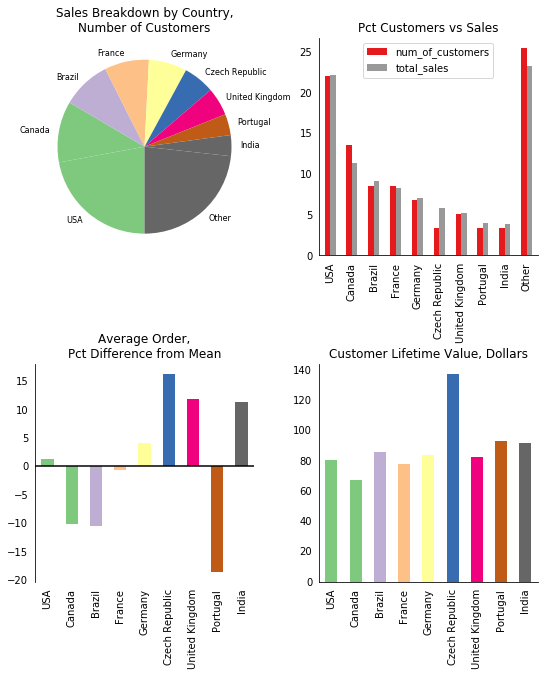

In [17]:
country_metrics = run_query(q)
country_metrics.set_index("country_group", inplace=True)
#Set one colour for each of the countries
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["num_of_customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["avg_sales_per_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["avg_sales_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

After having a look on the 4th graph, we can see that top countries regarding the average value per customers are:
- Czech Republic
- Portugal
- India
- Brazil
- Germany
- UK

However, this value considers all the orders from a country. We can now take a look on the average value per order (3rd graph). At this point, the top countries are:
- Czech Republic
- UK
- India

We can use that as reference to decide where to start campaigns, as each sale will bring more benefits for us. However, in the 3 cases we only have 2-3 customers. Even though it is an indicator, the sample might be too small to extract generic conclusions.

## Case 4: Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:
- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:
- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

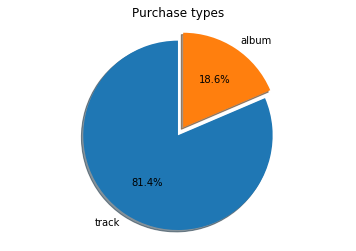

In [60]:
q='''
WITH
    invoice_first_track AS (
        SELECT
            il.invoice_id,
            MIN(il.track_id) first_track
        FROM invoice_line il
        GROUP BY 1
    ),
    album_or_track AS (
        SELECT
            ift.*,
            CASE
                WHEN (
                    SELECT t.track_id
                    FROM track t
                    WHERE t.album_id = (
                        SELECT t2.album_id
                        FROM track t2
                        WHERE t2.track_id = ift.first_track
                    )
                    
                EXCEPT
                
                    SELECT il2.track_id
                    FROM invoice_line il2
                    WHERE il2.invoice_id = ift.invoice_id
                ) IS NULL
                
                AND
                
                (
                    SELECT il2.track_id
                    FROM invoice_line il2
                    WHERE il2.invoice_id = ift.invoice_id
                    
                EXCEPT
                
                    SELECT t.track_id
                    FROM track t
                    WHERE t.album_id = (
                        SELECT t2.album_id
                        FROM track t2
                        WHERE t2.track_id = ift.first_track
                    )
                ) IS NULL
                THEN "album"
                ELSE "track"
            END AS purchase
        FROM invoice_first_track ift
    )
    
SELECT
    aot.purchase,
    COUNT(aot.invoice_id) number_of_invoices,
    ROUND(CAST(COUNT(aot.invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) * 100, 2) percentage
FROM album_or_track aot
GROUP BY 1
ORDER BY 2 DESC
'''

purchase_options = run_query(q)
purchase_options.set_index("purchase", inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(purchase_options["percentage"], explode=explode, labels=purchase_options.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Purchase types")

plt.show()


We can see that the 18.6% of the invoices refers to the purchase of a whole album. According to this, we must evaluate if we change our strategy to offer only some tracks of an album or not.
We might save money but there is a risk to lose part of this 18,6% of purchases (if the customer wants the full album).